In [107]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.utils.platform import get_num_workers
from torchlake.image_classification.models.mobilenet import MobileNetV1
from torchvision import transforms
from torchvision.datasets import GTSRB

# Setting

In [108]:
IMAGE_SIZE = 256
CROP_SIZE = 256
BATCH_SIZE = 128

In [109]:
artifact_path = Path("../../artifacts/mobilenet")
data_path = Path("../../data/gtsrb")

In [110]:
device = torch.device("cuda:0")

# data

In [111]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.1,
        ),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomCrop((CROP_SIZE, CROP_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [112]:
train_dataset = GTSRB(
    data_path.as_posix(),
    split="train",
    transform=preprocess,
    download=True,
)

In [113]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [114]:
num_class = 43

In [115]:
len(train_dataset)

26640

13


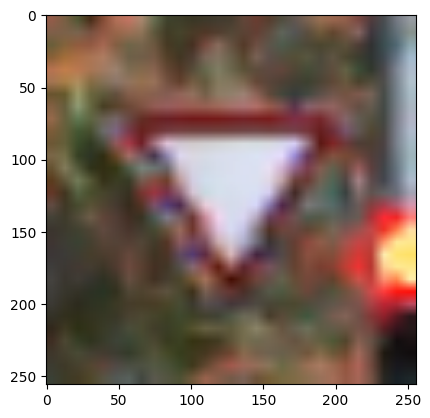

In [116]:
import random
from torchlake.common.utils.convert import img_tensor_to_np

demo_img, demo_label = random.choice(train_dataset)
print(demo_label)
plt.imshow((img_tensor_to_np(demo_img) * IMAGENET_STD + IMAGENET_MEAN).clip(0, 1))

# model

In [117]:
model = MobileNetV1(output_size=num_class).to(device)

In [118]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
MobileNetV1                                   --
├─Sequential: 1-1                             --
│    └─Conv2dNormActivation: 2-1              --
│    │    └─Conv2d: 3-1                       864
│    │    └─BatchNorm2d: 3-2                  64
│    │    └─ReLU: 3-3                         --
│    └─DepthwiseSeparableConv2d: 2-2          --
│    │    └─ConvBnRelu: 3-4                   352
│    │    └─ConvBnRelu: 3-5                   2,176
│    └─DepthwiseSeparableConv2d: 2-3          --
│    │    └─ConvBnRelu: 3-6                   704
│    │    └─ConvBnRelu: 3-7                   8,448
│    └─DepthwiseSeparableConv2d: 2-4          --
│    │    └─ConvBnRelu: 3-8                   1,408
│    │    └─ConvBnRelu: 3-9                   16,640
│    └─DepthwiseSeparableConv2d: 2-5          --
│    │    └─ConvBnRelu: 3-10                  1,408
│    │    └─ConvBnRelu: 3-11                  33,280
│    └─DepthwiseSeparableConv2d: 2-6     

# training

In [119]:
epoches = 10
acc_iters = 256 // BATCH_SIZE

In [120]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [121]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters())

In [122]:
from torchlake.common.controller.recorder import TrainRecorder

recorder = TrainRecorder(total_epoch=epoches)
recorder.increment_data_size(len(train_dataset))

In [123]:
scaler = torch.cuda.amp.GradScaler()

In [124]:
# for custom start point, comment this line
recorder.reset_epoch()

In [125]:
training_loss = trainer.run(
    train_loader,
    model,
    optim,
    criterion,
    scaler=scaler,
    recorder=recorder,
)

Enable AMP: True
Training...


100%|██████████| 208/208 [02:15<00:00,  1.53it/s]


------------------------------------
Epoch 1
------------------------------------
0.010816334212596 (0%)


100%|██████████| 208/208 [01:43<00:00,  2.00it/s]


------------------------------------
Epoch 2
------------------------------------
0.0033061060170690576 (-69%)


100%|██████████| 208/208 [01:37<00:00,  2.13it/s]


------------------------------------
Epoch 3
------------------------------------
0.0008743180608091586 (-74%)


100%|██████████| 208/208 [01:37<00:00,  2.14it/s]


------------------------------------
Epoch 4
------------------------------------
0.00039218695080551027 (-55%)


100%|██████████| 208/208 [01:38<00:00,  2.12it/s]


------------------------------------
Epoch 5
------------------------------------
0.00019177047863697724 (-51%)


100%|██████████| 208/208 [01:36<00:00,  2.15it/s]


------------------------------------
Epoch 6
------------------------------------
0.00013221539562224068 (-31%)


100%|██████████| 208/208 [01:37<00:00,  2.14it/s]


------------------------------------
Epoch 7
------------------------------------
0.00010994061381575665 (-17%)


100%|██████████| 208/208 [01:36<00:00,  2.15it/s]


------------------------------------
Epoch 8
------------------------------------
7.402718465008937e-05 (-33%)


100%|██████████| 208/208 [01:36<00:00,  2.15it/s]


------------------------------------
Epoch 9
------------------------------------
6.190673379974251e-05 (-16%)


100%|██████████| 208/208 [01:36<00:00,  2.16it/s]

------------------------------------
Epoch 10
------------------------------------
6.31364499947319e-05 (2%)


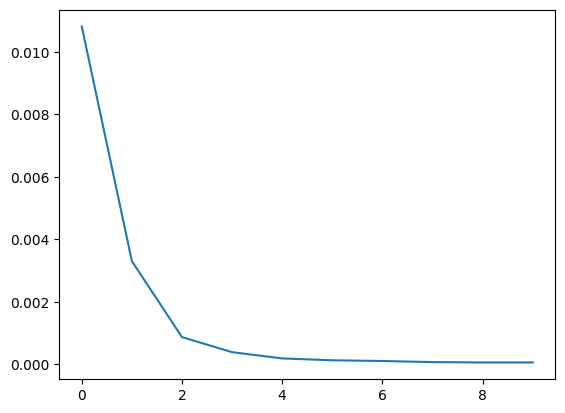

In [126]:
plt.plot(training_loss)

# inference

In [127]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.CenterCrop((CROP_SIZE, CROP_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [128]:
test_dataset = GTSRB(
    data_path.as_posix(),
    split="test",
    transform=test_preprocess,
    download=True,
)

In [129]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [130]:
evaluator = ClassificationEvaluator(num_class, device)

In [131]:
confusion_matrix = evaluator.run(test_loader, model)

100%|██████████| 99/99 [00:29<00:00,  3.34it/s]

[[ 37  21   0 ...   0   0   0]
 [  4 704   3 ...   0   0   0]
 [  0   8 726 ...   0   0   0]
 ...
 [  0   0   1 ...  82   0   0]
 [  0   0   0 ...   0  41   2]
 [  0   0   0 ...   0   6  60]]


In [132]:
print(confusion_matrix)

[[ 37  21   0 ...   0   0   0]
 [  4 704   3 ...   0   0   0]
 [  0   8 726 ...   0   0   0]
 ...
 [  0   0   1 ...  82   0   0]
 [  0   0   0 ...   0  41   2]
 [  0   0   0 ...   0   6  60]]


In [133]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(range(num_class), per_class_acc)

0         : 0.6166666666666667
1         : 0.9777777777777777
2         : 0.968
3         : 0.8933333333333333
4         : 0.9303030303030303
5         : 0.9253968253968254
6         : 0.94
7         : 0.9577777777777777
8         : 0.8866666666666667
9         : 0.975
10        : 0.9818181818181818
11        : 0.9761904761904762
12        : 0.9869565217391304
13        : 0.9944444444444445
14        : 0.9962962962962963
15        : 0.9952380952380953
16        : 0.94
17        : 0.9138888888888889
18        : 0.782051282051282
19        : 0.95
20        : 0.6111111111111112
21        : 0.6333333333333333
22        : 0.7416666666666667
23        : 0.96
24        : 0.9444444444444444
25        : 0.9875
26        : 0.95
27        : 0.7333333333333333
28        : 0.9533333333333334
29        : 0.9444444444444444
30        : 0.5933333333333334
31        : 1.0
32        : 0.8
33        : 0.7714285714285715
34        : 0.8916666666666667
35        : 0.958974358974359
36        : 0.9583333333

In [ ]:
# resize 224 / resize 224: 0.8197
# resize 256 / resize 256: 0.8654
# resize 256, random 224 / resize 256: 0.8101
# resize 256, random 224 / resize 256, center 224: 0.8447
# resize 256, random 224, color jitter / resize 256, center 224: 0.8527
per_class_acc.mean()

0.8654574545964837

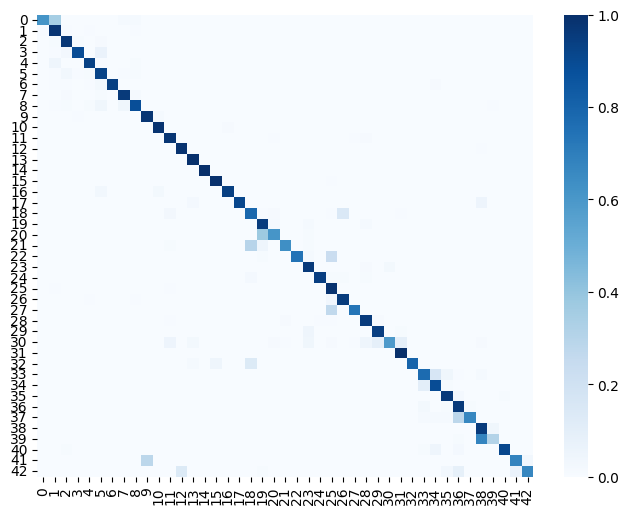

In [136]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    range(num_class),
    "Blues",
    annot=False,
    figsize=(8, 6),
)

# file

In [137]:
from torchlake.common.controller.weight_manager import WeightManager

In [138]:
manager = WeightManager(artifact_path.joinpath('mobilenetV1.{epoch}.pth').as_posix())

In [139]:
filename = manager.get_filename(epoch=recorder.current_epoch)
filename

WindowsPath('../../artifacts/mobilenet/mobilenetV1.10.pth')

In [140]:
manager.save_weight(model.state_dict(), filename)

Save weight to ..\..\artifacts\mobilenet\mobilenetV1.10.pth, model size is 12.54MiB


In [141]:
manager.load_weight(filename, model)